# Creating gymnasium environment

This environment goal: a simple $N \times N$ grid with black(wall) and white(track)

Car (Blue car) moving : Up, Down, Right, Left

End: Red

Start: Start

Observation grid: $n \times n$ with $n \leq N$

### Packages

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

In [24]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __mul__(self, other):
        if type(other) == int or type(other)==float:
            x,y = self.get()
            return Coor((x*other, y*other))
        else:
            raise NotImplementedError
    
    def dist(self, coor2):
        a,b = self.get()
        c,d = self.get()
        return np.sqrt(a*c + b*d)


N = 5
n = 5

RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [255 for _ in range(3)]

START_CHAR = "s"
END_CHAR = "e"

def color(b):
    if b == START_CHAR:
        return GREEN
    elif b == END_CHAR:
        return RED
    elif b == 1:
        return GREY
    else:
        return WHITE


class Track():
    def __init__(self, tab):
        self.height = len(tab)
        self.width = len((tab[0]))
        self.info_track = tab
        self.color_track = [[color(x) for x in y] for y in tab]

        self.end = None
        self.start = None
        for i in range(self.height):
            for j in range(self.width):
                if tab[i][j] == START_CHAR:
                    self.start = Coor((i,j))
                if tab[i][j] == END_CHAR:
                    self.end = Coor((i,j))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        x,y = int(x), int(y)
        return (self.info_track[x][y] == 1)

    def get_start(self):
        """Return coordinate of start"""
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()

    def plot(self):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track)
        plt.axis("off")
        plt.show()

### Track

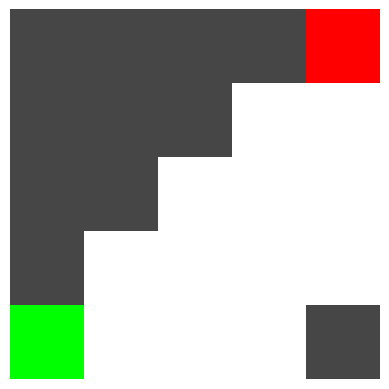

start at coordinates: (4, 0)


In [25]:
track_1_bool = [[1, 1, 1, 1, "e"],
                [1, 1, 1, 0, 0],
                [1, 1, 0, 0, 0],
                [1, 0, 0, 0, 0],
                ["s", 0, 0, 0, 1]]

track_1 = Track(track_1_bool)
track_1.plot()
print("start at coordinates:", track_1.get_start())

### Car Icon

In [26]:
CAR_ICON = [[BLUE]]

### Creating env

In [31]:
class MyEnv(Env):
    def __init__(self, track: Track, K=1):
        super(MyEnv, self).__init__()

        # Define a 2-D observation space
        self.observation_shape = (N, N, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.int64)

        # Define an action space ranging from 0 to 3
        self.action_space = [i for i in range(4)]

        self.track = track
        self.car = Coor(self.track.get_start())
        # self.car_icon = cv2.imread("blue_dot.png") /255
        self.car_icon = np.array(CAR_ICON)

        self.canvas = np.array(self.track.color_track)

        self.action_meanings = {0: "Right", 1: "Left", 2: "Down", 3: "Up"}
        self.meanings_action = {"R":0, "L":1, "D":2, "U":3}
        self.moves = {0:Coor((0,1)), 1:Coor((0,-1)), 2:Coor((1,0)), 3:Coor((-1,0))}
        for k in self.moves.keys():
            self.moves[k]*= K


    def reset(self):
        """Reset the environment"""
        self.car = Coor(self.track.get_start())
        return self.canvas

    def render(self, mode = "human", waiting_time=0.1):
        """Render the environment"""
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        self.canvas = np.array(self.track.color_track)
        if mode == "human":
            plt.imshow(self.canvas)
            plt.axis("off")
            plt.plot(self.car.x, self.car.y, 'o', color="blue")
            display.clear_output(wait=True)
            plt.show()
            time.sleep(waiting_time)

        

    def move(self, action):
        """Return the move cooresponding to action"""
        return self.moves[action]

    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the case or not"""
        x,y = coor.get()
        if not (x>=0 and x<self.track.height and y>=0 and y<self.track.width):
            return False
        return not self.track.is_wall(coor)
    
    def possible_action(self):
        """Return a list of possible action according to the coordinates of the car"""
        actions = []
        for k in self.moves.keys():
            if self.is_case_ridable(self.car + self.moves[k]):
                actions.append(k)
        return actions
        
    def step(self, action):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        reward = -1

        mv = self.move(action)
        next_move = self.car + mv
        reward += next_move.dist(self.track.end) - self.car.dist(self.track.end)
        self.car = next_move

        x,y = self.car.get()
        x,y = int(x),int(y)
        if Coor((x,y)) == self.track.end:
            reward = 200
            is_done = True

        return self.canvas, reward, is_done, []
    
    def random_action(self):
        """Return random possible action"""
        return rd.choice(self.possible_action())
        
        

env = MyEnv(track_1, K=1/2)
obs = env.reset()

### Running

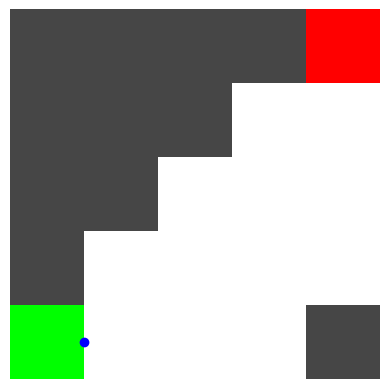

number of steps: 297


In [38]:
running = True
step = 0
env.reset()
while running:
    step += 1
    # Take a random action
    action = env.random_action()
    obs, reward, done, info = env.step(action)

    # Render the game
    env.render(waiting_time=0.01)

    if done == True or step > 1000:
        running = False

print("number of steps:", step)

env.close()